In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from scipy.signal import correlate

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

import sys
sys.path.append("..")
import models
import h5py
import data
import inference

from tqdm.notebook import tqdm


%load_ext autoreload
%autoreload 2

In [11]:
def semblance(data):
    nx, nt = data.shape
    # cross correlate and shift
    for i in range(nx-1):
        data = moveout_correction(data, i)
    
    return np.sum(np.sum(data, axis=0)**2) / np.sum(data**2) / nx

def moveout_correction(x, idx, thresh=0.7):
    # N = 2 * len(x[idx]) - 1
    # X = np.fft.fft(x[idx], n=N)
    # Y = np.fft.fft(x[idx+1], n=N)
    # corr = np.fft.fftshift(np.fft.ifft(X*Y.conj()).real)
    corr = correlate(x[idx], x[idx+1], mode='full') # (2 * len(x) - 1,)
    shift = np.argmax(corr) - (len(x[idx]) - 1)
    
    ashift = abs(shift)
    pad1 = np.zeros((idx+1, ashift))
    pad2 = np.zeros((x.shape[0] - (idx+1), ashift))
    if shift > 0 and np.corrcoef(x[idx,shift:], x[(idx+1),:-shift], rowvar=False)[0,1] > thresh:
        x = np.concatenate(
            [np.concatenate([x[:(idx+1)], pad1], axis=1),
             np.concatenate([pad2, x[(idx+1):]], axis=1)],
            axis=0)
    if shift < 0 and np.corrcoef(x[idx,:-shift], x[(idx+1),shift:], rowvar=False)[0,1] > thresh:
        x = np.concatenate(
            [np.concatenate([pad1, x[:(idx+1)]], axis=1),
             np.concatenate([x[(idx+1):], pad2], axis=1)],
            axis=0)
    return x

def moving_window_semblance(data, size=(15,25)):
    
    nx, nt = data.shape
    result = np.zeros((nx-size[0]+1, nt-size[1]+1))
    
    for i in tqdm(range(result.shape[0])):
        for j in range(result.shape[1]):
            result[i,j] = semblance(data[i:i+size[0],j:j+size[1]])
    
    return result

In [ ]:
fs = 50.0

file = '../data/preprocessed/real_test/2023p181489.h5'
idx = 6250

with h5py.File(file, 'r') as hf:
    samples = hf['DAS'][81:,idx-3072:idx+3072]

gutter = 1000
x = np.pad(samples[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
x = data.bandpass(x, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]
x = x / x.std(axis=-1, keepdims=True)
np.save('../data/2023p181489_input.npy', x)

plt.imshow(x, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)

In [13]:
if not os.path.isfile('../data/2023p181489_output.npy'):

    model = models.CN2SUNet(1, 1, hidden_ch=32, n_layers=4).to(device)
    model.load_state_dict(torch.load('../ckpt/CN2S-finetuned4-complement-128x512-16x180_200.pt'))
    model.eval()

    rec = inference.xreconstruct(model, torch.from_numpy(x).to(device), 128, 512, 16, nx_stride=6, nt_stride=50, batch_size=128, dx=4, verbose=False)
    rec_filt = np.pad(rec.cpu().numpy()[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
    rec_filt = data.bandpass(rec_filt, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]

    np.save('../data/2023p181489_output.npy', rec_filt)

In [14]:
x = np.load('../data/2023p181489_input.npy')
output = np.load('../data/2023p181489_output.npy')

x = x[:,70:70+6000]
output = output[:,70:70+6000]

In [16]:
x1, y1 = 2500, 14000 // 4
x2, y2 = 2000, 3000 // 4
w, h = 1500, 4000 // 4
idx = 3

if not os.path.isfile('../data/semblance15x25_input_01.npy'):
    S = moving_window_semblance(x[y1:y1+h, x1:x1+w])
    np.save('./data/semblance15x25_input_01', S)
    plt.imshow(S / (1-S), origin='lower', interpolation='antialiased', cmap='viridis', aspect='auto', vmin=0, vmax=5)
    plt.show()

if not os.path.isfile('../data/semblance15x25_input_02.npy'):
    S = moving_window_semblance(x[y2:y2+h, x2:x2+w])
    np.save('./data/semblance15x25_input_02.npy', S)
    plt.imshow(S / (1-S), origin='lower', interpolation='antialiased', cmap='viridis', aspect='auto', vmin=0, vmax=5)
    plt.show()

if not os.path.isfile('../data/semblance15x25_output_01.npy'):
    S = moving_window_semblance(output[y1:y1+h, x1:x1+w])
    np.save('./data/semblance15x25_output_01', S)
    plt.imshow(S / (1-S), origin='lower', interpolation='antialiased', cmap='viridis', aspect='auto', vmin=0, vmax=5)
    plt.show()

if not os.path.isfile('../data/semblance15x25_output_02.npy'):
    S = moving_window_semblance(output[y2:y2+h, x2:x2+w])
    np.save('./data/semblance15x25_output_02.npy', S)
    plt.imshow(S / (1-S), origin='lower', interpolation='antialiased', cmap='viridis', aspect='auto', vmin=0, vmax=5)
    plt.show()

In [18]:
S_input1 = np.load('../data/semblance15x25_input_01.npy')
S_input1 = np.pad(S_input1, ((5,5),(5,5)))
S_input2 = np.load('../data/semblance15x25_input_02.npy')
S_input2 = np.pad(S_input2, ((5,5),(5,5)))
S_rec1 = np.load('../data/semblance15x25_output_01.npy')
S_rec1 = np.pad(S_rec1, ((5,5),(5,5)))
S_rec2 = np.load('../data/semblance15x25_output_02.npy')
S_rec2 = np.pad(S_rec2, ((5,5),(5,5)))

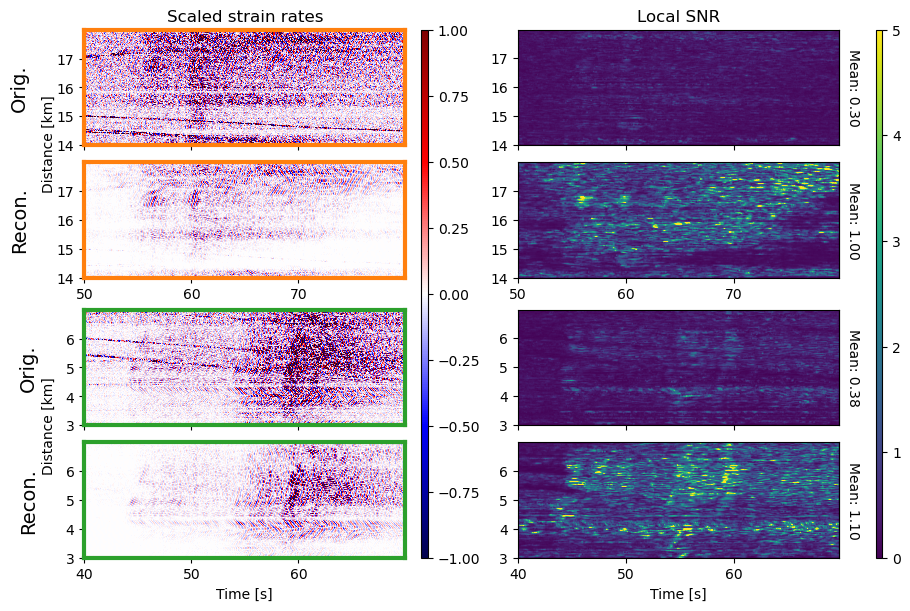

In [20]:
x1, y1 = 2500, 14000 // 4
x2, y2 = 2000, 3000 // 4
w, h = 1500, 4000 // 4

idx = 3
lw = 3
alpha = 0.5

fig, axs = plt.subplot_mosaic([['a','aa'],
                               ['b','bb'],
                               ['c','cc'],
                               ['d','dd']],
                              layout='constrained', figsize=(9,6))

axs['a'].imshow(x[y1:y1+h, x1:x1+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
axs['b'].imshow(output[y1:y1+h, x1:x1+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
axs['c'].imshow(x[y2:y2+h, x2:x2+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
im = axs['d'].imshow(output[y2:y2+h, x2:x2+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
fig.colorbar(im, ax=[axs['a'], axs['b'], axs['c'], axs['d']], location='right', shrink=1, aspect=80, pad=0.05)

vmax = 5
axs['aa'].imshow(S_input1 / (1-S_input1), origin='lower', interpolation='antialiased', cmap='viridis', aspect='auto', vmin=0, vmax=vmax)
axs['bb'].imshow(S_rec1 / (1-S_rec1), origin='lower', interpolation='antialiased', cmap='viridis', aspect='auto', vmin=0, vmax=vmax)
axs['cc'].imshow(S_input2 / (1-S_input2), origin='lower', interpolation='antialiased', cmap='viridis', aspect='auto', vmin=0, vmax=vmax)
im = axs['dd'].imshow(S_rec2 / (1-S_rec2), origin='lower', interpolation='antialiased', cmap='viridis', aspect='auto', vmin=0, vmax=vmax)
fig.colorbar(im, ax=[axs['aa'], axs['bb'], axs['cc'], axs['dd']], location='right', shrink=1, aspect=80, pad=0.05)


for s in ['a', 'b', 'aa', 'bb', 'c', 'd', 'cc', 'dd']:
    axs[s].set_xticks([i for i in range(0,w,500)])
    axs[s].set_yticks([i for i in range(0,h,250)])


for s in ['a', 'b', 'aa', 'bb']:
    axs[s].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x1) / 50))}'))
    axs[s].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + y1) * 0.004))}')) 
for s in ['c', 'd', 'cc', 'dd']:
    axs[s].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x2) / 50))}'))
    axs[s].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + y2) * 0.004))}'))

axs['a'].set_title('Scaled strain rates')
axs['aa'].set_title('Local SNR')

axs['a'].set_xticklabels([])
axs['aa'].set_xticklabels([])
axs['c'].set_xticklabels([])
axs['cc'].set_xticklabels([])

axs['d'].set_xlabel('Time [s]')
axs['dd'].set_xlabel('Time [s]')

aa_bbox = axs['aa'].get_position()
bb_bbox = axs['bb'].get_position()
center_x = (aa_bbox.x0 + bb_bbox.x0) / 2
fig.text(0.04, 0.77, 'Distance [km]', rotation=90, va='center', fontsize=10)
fig.text(0.04, 0.3, 'Distance [km]', rotation=90, va='center', fontsize=10)

fs = 14
axs['a'].set_ylabel('Orig.', labelpad=20, fontsize=fs)
axs['b'].set_ylabel('Recon.', labelpad=20, fontsize=fs)
axs['c'].set_ylabel('Orig.', labelpad=20, fontsize=fs)
axs['d'].set_ylabel('Recon.', labelpad=20, fontsize=fs)

secax = axs['aa'].secondary_yaxis('right')
secax.set_yticks([])
secax.set_ylabel('Mean: {:.2f}'.format(np.mean(S_input1 / (1-S_input1))), labelpad=15, rotation=270)

secax = axs['bb'].secondary_yaxis('right')
secax.set_yticks([])
secax.set_ylabel('Mean: {:.2f}'.format(np.mean(S_rec1 / (1-S_rec1))), labelpad=15, rotation=270)

secax = axs['cc'].secondary_yaxis('right')
secax.set_yticks([])
secax.set_ylabel('Mean: {:.2f}'.format(np.mean(S_input2 / (1-S_input2))), labelpad=15, rotation=270)

secax = axs['dd'].secondary_yaxis('right')
secax.set_yticks([])
secax.set_ylabel('Mean: {:.2f}'.format(np.mean(S_rec2 / (1-S_rec2))), labelpad=15, rotation=270)

for a in ['a', 'b']:
    for b in ['bottom', 'top', 'right', 'left']:
        axs[a].spines[b].set_color('tab:orange')
        axs[a].spines[b].set_linewidth(lw)
        
for a in ['c', 'd']:
    for b in ['bottom', 'top', 'right', 'left']:
        axs[a].spines[b].set_color('tab:green')
        axs[a].spines[b].set_linewidth(lw)

plt.savefig('./out/figure_09.pdf', bbox_inches='tight', dpi=200)
plt.show()